# Fraction of pairwise edit-distance distribution

In [1]:
import os
import re

import Levenshtein
import numpy as np
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt

# Adjust the working directory
os.chdir('path_to_your_dir')

In [2]:
#https://maxbachmann.github.io/Levenshtein/levenshtein.html
def distance_matrix(positive, negative=None):
    
    # Initiate empty distance matrix
    distance_matrix = []
    tcrs=[]

    # Calculate distance between every pairwise combination of positive TCRs
    if negative == None:
        for TCRi in positive:
            dist = []
            for TCRj in positive:
                ld = Levenshtein.distance(TCRi, TCRj)
                dist.append(ld)  
            distance_matrix.append(dist)
            tcrs.append(TCRi)
    # Calculate distance between every pairwise combination of positive and negative TCRs
    else:
        for TCRi in positive:
            dist = []
            for TCRj in negative:
                ld = Levenshtein.distance(TCRi, TCRj)
                dist.append(ld)  
            distance_matrix.append(dist)
            tcrs.append(TCRi)
        
    return distance_matrix,tcrs


def distance_range(dm, tcrs, positive=None):
    min_distance = []
    max_distance = []
    
    # Find the min and max distances for every TCR int the positive or negative data set
    for i in dm:
        if positive==True:
            # Remove the first 0 (i.e. identical match)
            i.remove(0)
            dmin = 'min_pos_distance'
            dmax = 'max_pos_distance'
        else:
            # Do not remove first mach anymore when calculating distance with negative set
            dmin = 'min_back_distance'
            dmax = 'max_back_distance'
            
        # Find the min and max edit distance for each TCR with another TCR
        min_d = (min(i))
        max_d = (max(i))
        min_distance.append(min_d)
        max_distance.append(max_d)

    summary = {dmin: min_distance, dmax: max_distance, 'tcr':tcrs}
    summary_df = pd.DataFrame(data=summary)
    
    return(summary_df)

In [3]:
# Get all epitope sequences
df = pd.read_csv('./data/final/all_tcrs.tsv')
epitopes = set(df['epitope'].tolist())

In [4]:
final = pd.DataFrame()

for epitope in epitopes:
    
    data = pd.read_csv(os.path.join('data/parsed/tcrex_data',epitope,'training_data.tsv'), sep='\t')
    
    # No set as multiple cdr3s with different v/j genes can be present
    positive = data[data['Class']==1]['CDR3_beta'].tolist()
    negative = data[data['Class']==0]['CDR3_beta'].tolist()
    
    # epitope-specific distances
    dm,tcrs = distance_matrix(positive, negative=None)
    # Get frequencies of min and max distances
    pos = distance_range(dm,tcrs,positive=True).set_index('tcr')
    
    # Background distances
    # Calculate distance matrix from repertoire
    dm,tcrs = distance_matrix(positive,negative)
    # Get frequencies of min an max distances
    back = distance_range(dm,tcrs, positive=False).set_index('tcr')
    #https://stackoverflow.com/questions/48331994/saving-high-resolution-images-with-plotnine
    
    # Get the minimal distance between positive and negative data
    count = back.groupby(['min_back_distance']).size().reset_index().rename(columns={0:'Count'})
    cm = count['min_back_distance'].min()
    # Count the nr of occurences with this minimal distance
    count = count[count['min_back_distance'] == cm]['Count'].tolist()[0]

    # Combine the epitope-specific and background distances for every TCR in the positive dataset
    summary = pd.concat([pos,back],axis=1)
    summary['FRAC_min'] = summary['min_pos_distance']/summary['min_back_distance']
    summary['FRAC_max'] = summary['max_pos_distance']/summary['max_back_distance']
    summary['epitope'] = epitope
    
    med_min = summary['FRAC_min'].median()
    mean_min = summary['FRAC_min'].mean()
    med_max = summary['FRAC_max'].median()
    mean_max = summary['FRAC_max'].mean()
    
    stats = {'med_min': [med_min], 'mean_min': [mean_min],
             'med_max': [med_max],'mean_max': [mean_max],
             'min_distance': cm,'count_min': count,
             'epitope':[epitope]}
    stats = pd.DataFrame(data=stats)
    final = pd.concat([final,stats])
    

In [5]:
# Add performance metrics to df
def get_values(tcrex,epitope,column):
    return tcrex[tcrex['epitope']==epitope][column].tolist()[0]


tcrex = pd.read_csv('./data/parsed/tcrex_models.csv')

final['roc'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'roc_auc'))
final['Average precision'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'average_precision'))
final['accuracy'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'accuracy'))
final['size'] = final['epitope'].apply(lambda x: get_values(tcrex,x,'nr_target_sequences'))
final

,med_min,mean_min,med_max,mean_max,min_distance,count_min,epitope,roc,Average precision,accuracy,size
0,1.000000,1.144872,0.750000,0.760994,2,20,IPIQASLPF,0.737569,0.351617,0.514286,104
0,1.000000,1.134064,0.875000,0.893592,1,1,LPPAYTNSF,0.822369,0.449907,0.532000,127
0,1.000000,1.013218,0.857143,0.869412,1,1,SLYNTVATL,0.591523,0.395996,0.631609,58
0,1.250000,1.312698,0.923077,0.912841,2,4,NYSGVVTTVMF,0.678788,0.294667,0.512771,33
0,1.250000,1.230699,0.928571,0.918591,1,10,LEPLVDLPI,0.756841,0.352660,0.538502,367
...,...,...,...,...,...,...,...,...,...,...,...
0,1.000000,1.078462,0.785714,0.777182,2,13,KLVALGINAV,0.727751,0.507873,0.620000,65
0,1.333333,1.318333,0.923077,0.917912,2,11,LVLSVNPYV,0.659500,0.337707,0.499000,50
0,1.183333,1.160952,0.857143,0.839915,2,6,FADDLNQLTGY,0.702653,0.435834,0.614286,70
0,1.000000,0.990556,0.785714,0.794249,2,10,GTSGSPIIDK,0.738403,0.489193,0.607500,60


In [6]:
fig = (pn.ggplot(final, pn.aes('roc','med_min',colour='Average precision',label='epitope')) + 
       pn.geom_point() +
       #pn.geom_text(angle=90,size=5,color='black')+
       pn.theme_bw() +
       pn.labels.ylab('Median of the fraction of minimal distances') +
       pn.labels.xlab('AUROC') +
       pn.theme(figure_size=(12, 8))).draw(show=False)

fig.savefig('./figures/background/fraction_distances.pdf', dpi=300)



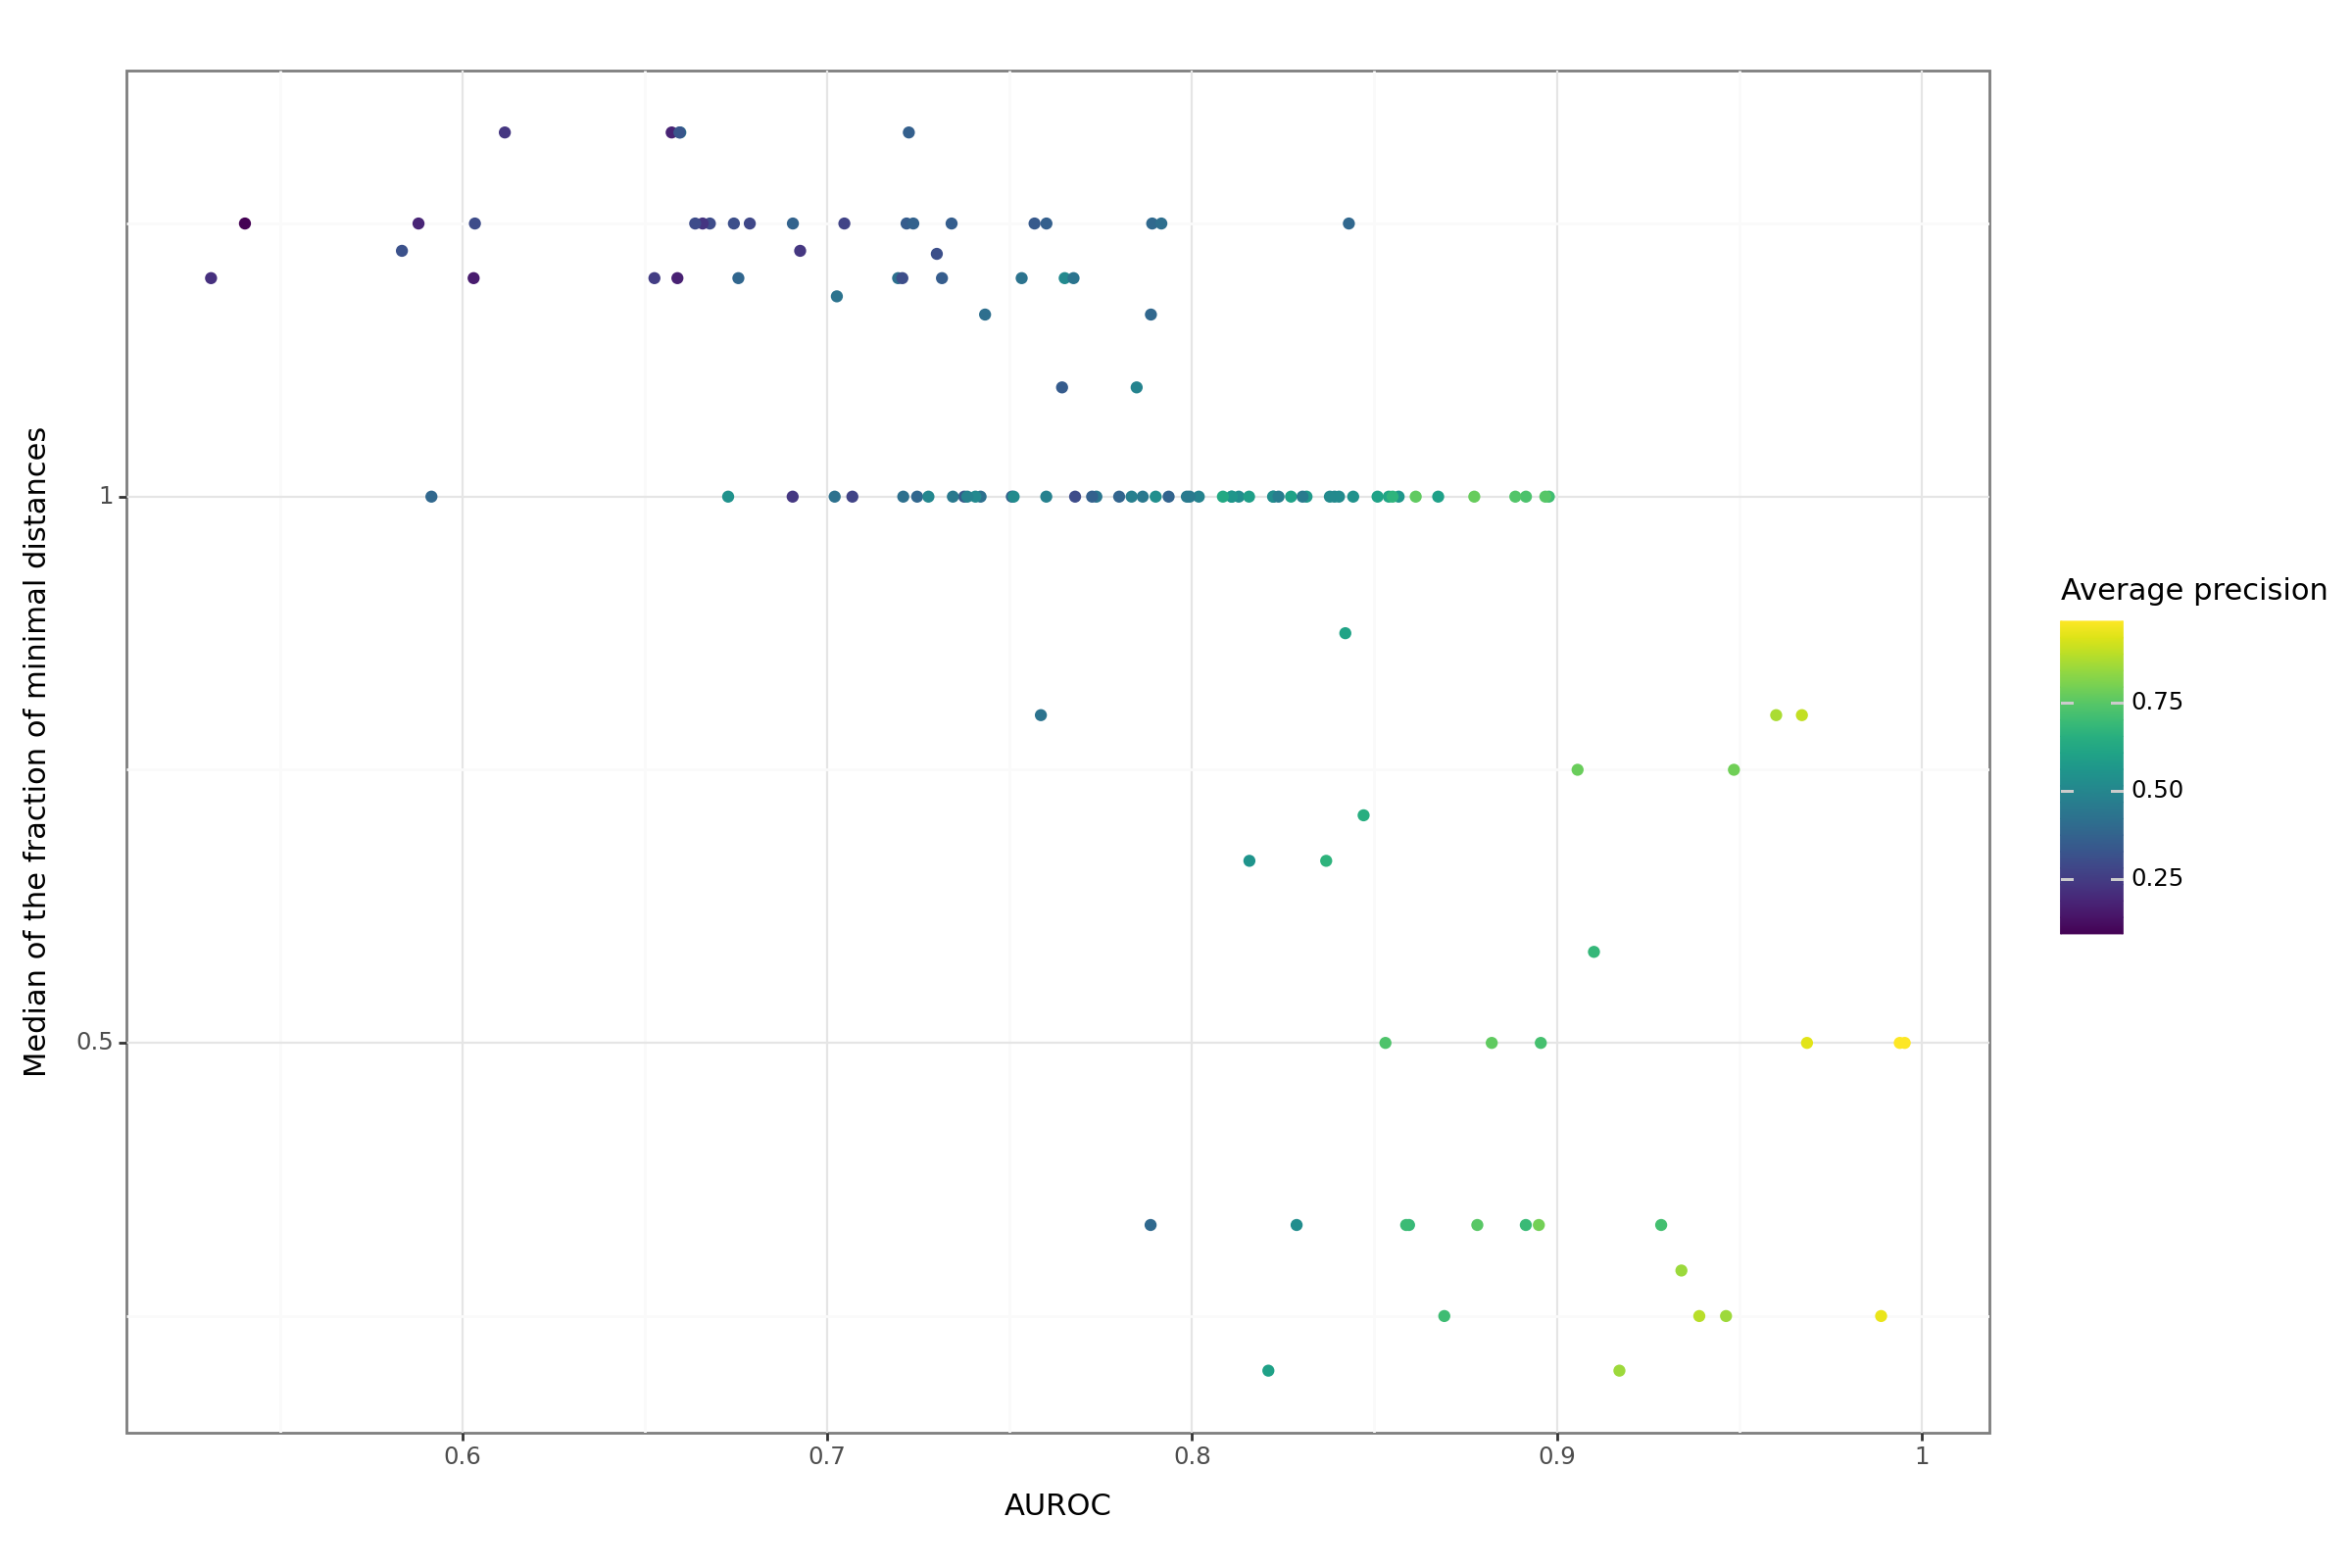

In [7]:
fig

In [8]:
### Save results
final = final[['min_distance','count_min','epitope']].sort_values(by=['min_distance','count_min'])
final.to_csv('./results/background/min_distances.tsv')
final

,min_distance,count_min,epitope
0,0,1,KRWIILGLNK
0,0,1,LLWNGPMAV
0,0,1,TLIGDCATV
0,0,2,VLWAHGFEL
0,0,2,GLCTLVAML
...,...,...,...
0,2,21,FLNRFTTTL
0,2,24,ATDALMTGY
0,2,26,KLNVGDYFV
0,2,31,TPQDLNTML


In [9]:
zero_distance = final[final['min_distance']==0]
zero_distance = zero_distance[['min_distance','count_min','epitope']].sort_values(by=['min_distance','count_min'])
zero_distance

,min_distance,count_min,epitope
0,0,1,KRWIILGLNK
0,0,1,LLWNGPMAV
0,0,1,TLIGDCATV
0,0,2,VLWAHGFEL
0,0,2,GLCTLVAML
0,0,2,KLPDDFTGCV
0,0,3,ELAGIGILTV
0,0,4,FLPRVFSAV
0,0,5,KLSYGIATV
0,0,9,FVDGVPFVV
